In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Load and prepare data
data = pd.read_csv('Test_Combined_Sales_Data.csv')
# Convert 'Date' to datetime format correctly accounting for day-first formats
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Ensure that there are no duplicate dates
if data['Date'].duplicated().any():
    print("Duplicates found! Aggregating data.")
    data = data.groupby('Date').agg({
        'TotalNetSales': 'sum',  # Sum sales
        'feelslike': 'mean',  # Average temperature
        'Is_Holiday': 'max'     # Maximum to get any holiday flagged if present
    }).reset_index()

# Set 'Date' as the index
data.set_index('Date', inplace=True)
# Check if the frequency conversion is necessary
if not data.index.is_monotonic_increasing:
    data = data.sort_index()

# Assume daily data frequency
data = data.asfreq('D', method='ffill')

# SARIMAX Model Configuration
# Example parameters - adjust based on your data
p = d = q = range(0, 2)  # ARIMA parameters
sp = sd = sq = s = range(0, 2)  # Seasonal parameters (assuming simple seasonality)
params = list(product(p, d, q, sp, sd, sq, s))

best_aic = float('inf')
best_params = None

# Grid search for best parameters
for param in params:
    try:
        model = SARIMAX(data['TotalNetSales'],
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        exog=data[['feelslike', 'Is_Holiday']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except Exception as e:
        print(f"An error occurred: {e}")

print('Best SARIMAX parameters:', best_params)
print('Best AIC:', best_aic)

# Fit the best model
model = SARIMAX(data['TotalNetSales'],
                order=(best_params[0], best_params[1], best_params[2]),
                seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
                exog=data[['feelslike', 'Is_Holiday']])
results = model.fit()
print(results.summary())


In [3]:
import numpy as np
# Assume additional data such as marketing spend and local events
data['MarketingSpend'] = np.random.normal(1000, 300, size=len(data))
data['LocalEvents'] = np.random.randint(0, 2, size=len(data))

# Including these new variables in the SARIMAX model
exog_vars = data[['feelslike', 'Is_Holiday', 'MarketingSpend', 'LocalEvents']]


In [4]:
# Interaction between temperature and holidays
data['Temp_Holiday_Interact'] = data['feelslike'] * data['Is_Holiday']

# Lagged sales variables
data['Lagged_Sales'] = data['TotalNetSales'].shift(1).fillna(method='bfill')


C:\Users\saika\AppData\Local\Temp\ipykernel_132672\1314009805.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Lagged_Sales'] = data['TotalNetSales'].shift(1).fillna(method='bfill')


In [5]:
from pmdarima import auto_arima

# Automatic model selection
auto_model = auto_arima(data['TotalNetSales'], exogenous=exog_vars,
                        seasonal=True, m=7,  # Assuming weekly seasonality
                        information_criterion='aic', trace=True,
                        error_action='ignore', suppress_warnings=True)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19722.943, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18827.914, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=19046.580, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19720.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=19677.028, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=18727.892, Time=2.54 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=18818.836, Time=1.45 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=18682.458, Time=3.78 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=18783.557, Time=1.08 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=11.31 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=18644.

In [6]:
from sklearn.metrics import mean_squared_error

def rolling_forecast_origin(data, exog_vars, start, end, step):
    history = data.loc[:start]
    predictions = []
    for t in range(start, end, step):
        model = SARIMAX(history['TotalNetSales'], order=(3,1,0), seasonal_order=(1,0,1,7),
                        exogenous=history[exog_vars])
        model_fit = model.fit(disp=0)
        output = model_fit.forecast(steps=step, exog=data.loc[t:t+step-1, exog_vars])
        predictions.append(output)
        history = history.append(data.loc[t:t+step-1])
    mse = mean_squared_error(data.loc[start:end, 'TotalNetSales'], predictions)
    print(f'Test MSE: {mse}')


Residuals Description: count    1128.000000
mean       -8.409820
std       884.988240
min     -6025.455359
25%      -548.875739
50%       -66.404244
75%       483.208969
max      4084.274370
dtype: float64


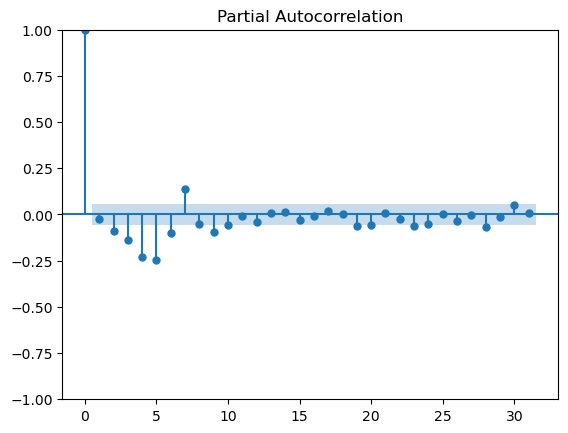

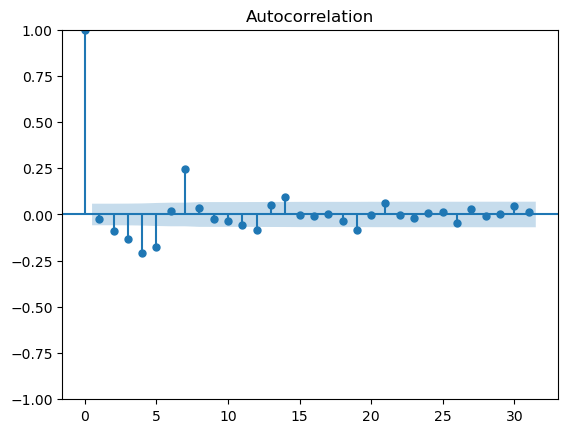

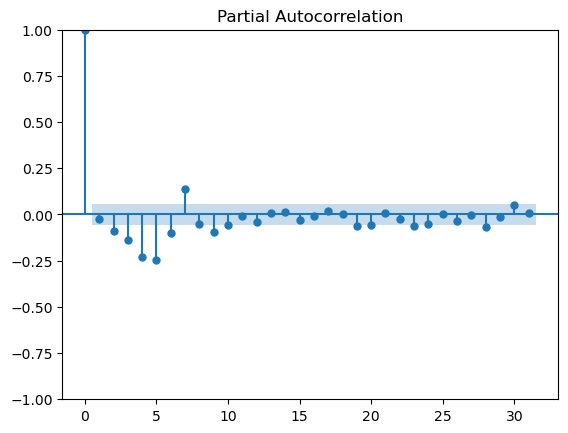

In [8]:
model_fit = SARIMAX(data['TotalNetSales'], order=(3,1,0),
                    seasonal_order=(1,0,1,7), exog=exog_vars).fit()

residuals = model_fit.resid
print('Residuals Description:', residuals.describe())

# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plot_pacf(residuals)


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(data['TotalNetSales'], model_fit.fittedvalues)
mse = mean_squared_error(data['TotalNetSales'], model_fit.fittedvalues)
rmse = np.sqrt(mse)
r2 = r2_score(data['TotalNetSales'], model_fit.fittedvalues)

print(f'MAE: {mae}, RMSE: {rmse}, R^2: {r2}')


MAE: 655.5511012058596, RMSE: 884.6358460763704, R^2: 0.6387747175934634


C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\sit

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Test MSE: 972824.1161719378
Test MAE: 746.0551928167393
Test RMSE: 986.3184658982807
Test R^2: 0.5140992845953781


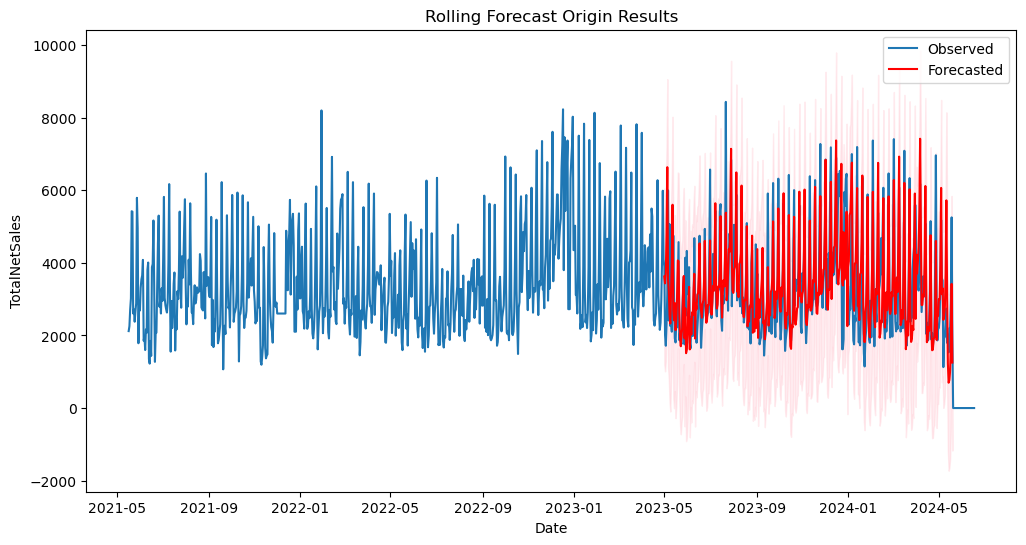

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv('Test_Combined_Sales_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format

# Handle duplicates by aggregating TotalNetSales and taking the mean for exogenous variables
data = data.groupby('Date').agg({
    'TotalNetSales': 'sum',
    'feelslike': 'mean',
    'Is_Holiday': 'max'  # Assuming holiday is a binary indicator
}).reset_index()

data.set_index('Date', inplace=True)
data = data.asfreq('D').ffill()  # Forward fill to ensure continuity

# Fill missing values for exogenous variables if necessary
data['feelslike'].ffill(inplace=True)
data['Is_Holiday'].fillna(0, inplace=True)

# Standardize the exogenous variables
scaler = StandardScaler()
data[['feelslike', 'Is_Holiday']] = scaler.fit_transform(data[['feelslike', 'Is_Holiday']])

# Define exogenous variables
exog_vars = ['feelslike', 'Is_Holiday']

# Rolling forecast origin function
def rolling_forecast_origin(data, exog_vars, start, end, step):
    history = data.loc[:start]
    predictions = []
    actuals = []
    for t in pd.date_range(start, end, freq=f'{step}D'):
        model = SARIMAX(history['TotalNetSales'], order=(3,1,0), seasonal_order=(1,0,1,7),
                        exog=history[exog_vars], enforce_stationarity=False, enforce_invertibility=False)
        try:
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=step, exog=data.loc[t:t+pd.Timedelta(days=step-1), exog_vars])
            predictions.extend(forecast)
            actuals.extend(data.loc[t:t+pd.Timedelta(days=step            -1), 'TotalNetSales'])
            history = pd.concat([history, data.loc[t:t+pd.Timedelta(days=step-1)]])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError encountered at {t}: {e}")
            continue
        except ValueError as e:
            print(f"ValueError encountered at {t}: {e}")
            continue
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    print(f'Test MSE: {mse}')
    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')
    print(f'Test R^2: {r2}')
    
    return predictions, actuals

# Define start and end points for the rolling forecast
start = pd.to_datetime('2023-05-01')  # Ensure this date exists in your data
end = pd.to_datetime('2024-05-19')    # Ensure this date exists in your data
step = 7  # Forecast one week at a time

# Run the rolling forecast origin
predictions, actuals = rolling_forecast_origin(data, exog_vars, start, end, step)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalNetSales'], label='Observed')
plt.plot(pd.date_range(start=start, periods=len(predictions), freq='D'), predictions, label='Forecasted', color='red')
plt.fill_between(pd.date_range(start=start, periods=len(predictions), freq='D'), 
                 np.array(predictions) - 1.96*np.std(predictions), 
                 np.array(predictions) + 1.96*np.std(predictions), color='pink', alpha=0.3)
plt.title('Rolling Forecast Origin Results')
plt.xlabel('Date')
plt.ylabel('TotalNetSales')
plt.legend()
plt.show()



import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv('Test_Combined_Sales_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data.drop_duplicates(subset='Date', inplace=True)  # Remove duplicate dates
data.set_index('Date', inplace=True)
data = data.asfreq('D').ffill()  # Forward fill to ensure continuity

# Fill missing values for exogenous variables if necessary
data['feelslike'].ffill(inplace=True)
data['Is_Holiday'].ffill(inplace=True)

# Add Pre-Christmas feature
data['year'] = data.index.year
data['pre_christmas'] = 0
for year in data['year'].unique():
    pre_christmas_start = pd.to_datetime(f'{year}-12-11')
    pre_christmas_end = pd.to_datetime(f'{year}-12-24')
    data.loc[(data.index >= pre_christmas_start) & (data.index <= pre_christmas_end), 'pre_christmas'] = 1

# Define exogenous variables including the pre-Christmas feature
exog_vars = ['feelslike', 'Is_Holiday', 'pre_christmas']

# Standardize exogenous variables
scaler = StandardScaler()
data[exog_vars] = scaler.fit_transform(data[exog_vars])

# Function for rolling forecast origin
def rolling_forecast_origin(data, exog_vars, start, end, step):
    history = data.loc[:start]
    predictions = []
    actuals = []
    
    for t in pd.date_range(start, end, freq=f'{step}D'):
        try:
            model = SARIMAX(history['TotalNetSales'], order=(3,1,0), seasonal_order=(1,0,1,7),
                            exog=history[exog_vars], enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=step, exog=data.loc[t:t+pd.Timedelta(days=step-1), exog_vars])
            predictions.extend(forecast)
            actuals.extend(data.loc[t:t+pd.Timedelta(days=step-1), 'TotalNetSales'])
            history = pd.concat([history, data.loc[t:t+pd.Timedelta(days=step-1)]])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError encountered at {t}: {e}")
            continue
        except ValueError as e:
            print(f"ValueError encountered at {t}: {e}")
            continue
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    print(f'Test MSE: {mse}')
    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')
    print(f'Test R^2: {r2}')
    
    return predictions, actuals

# Define start and end points for the rolling forecast
start = pd.to_datetime('2023-05-01')  # Ensure this date exists in your data
end = pd.to_datetime('2024-05-19')    # Ensure this date exists in your data
step = 7  # Forecast one week at a time

# Run the rolling forecast origin
predictions, actuals = rolling_forecast_origin(data, exog_vars, start, end, step)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalNetSales'], label='Observed')
plt.plot(pd.date_range(start=start, periods=len(predictions), freq='D'), predictions, label='Forecasted', color='red')
plt.fill_between(pd.date_range(start=start, periods=len(predictions), freq='D'), 
                 np.array(predictions) - 1.96*np.std(predictions), 
                 np.array(predictions) + 1.96*np.std(predictions), color='pink', alpha=0.3)
plt.title('Rolling Forecast Origin Results')
plt.xlabel('Date')
plt.ylabel('TotalNetSales')
plt.legend()
plt.show()


C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\sit

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Test MSE: 982107.2386307776
Test MAE: 750.0349619577463
Test RMSE: 991.0132383731196
Test R^2: 0.509462602826336
Test MAPE: 25.13%
Test SMAPE: 23.24%


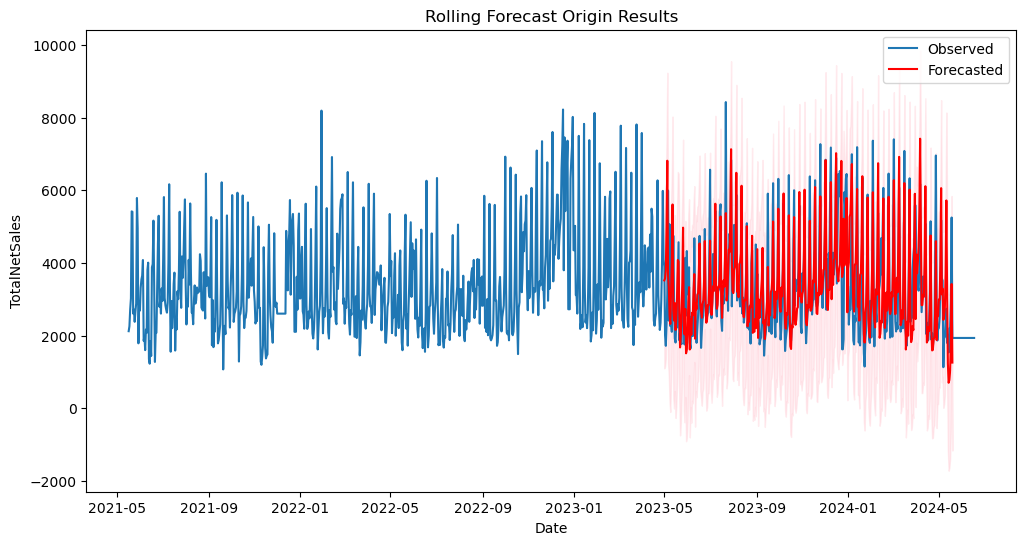

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare data
data = pd.read_csv('Test_Combined_Sales_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data.drop_duplicates(subset='Date', inplace=True)  # Remove duplicate dates
data.set_index('Date', inplace=True)
data = data.asfreq('D').ffill()  # Forward fill to ensure continuity

# Fill missing values for exogenous variables if necessary
data['feelslike'].ffill(inplace=True)
data['Is_Holiday'].ffill(inplace=True)

# Add Pre-Christmas feature
data['year'] = data.index.year
data['pre_christmas'] = 0
for year in data['year'].unique():
    pre_christmas_start = pd.to_datetime(f'{year}-12-11')
    pre_christmas_end = pd.to_datetime(f'{year}-12-24')
    data.loc[(data.index >= pre_christmas_start) & (data.index <= pre_christmas_end), 'pre_christmas'] = 1

# Define exogenous variables including the pre-Christmas feature
exog_vars = ['feelslike', 'Is_Holiday', 'pre_christmas']

# Standardize exogenous variables
scaler = StandardScaler()
data[exog_vars] = scaler.fit_transform(data[exog_vars])

# Function for rolling forecast origin
def rolling_forecast_origin(data, exog_vars, start, end, step):
    history = data.loc[:start]
    predictions = []
    actuals = []
    
    for t in pd.date_range(start, end, freq=f'{step}D'):
        try:
            model = SARIMAX(history['TotalNetSales'], order=(3,1,0), seasonal_order=(1,0,1,7),
                            exog=history[exog_vars], enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=step, exog=data.loc[t:t+pd.Timedelta(days=step-1), exog_vars])
            predictions.extend(forecast)
            actuals.extend(data.loc[t:t+pd.Timedelta(days=step-1), 'TotalNetSales'])
            history = pd.concat([history, data.loc[t:t+pd.Timedelta(days=step-1)]])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError encountered at {t}: {e}")
            continue
        except ValueError as e:
            print(f"ValueError encountered at {t}: {e}")
            continue
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    # Calculate MAPE
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    # Calculate SMAPE
    smape = np.mean(2.0 * np.abs(np.array(actuals) - np.array(predictions)) / (np.abs(np.array(actuals)) + np.abs(np.array(predictions)))) * 100
    
    print(f'Test MSE: {mse}')
    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')
    print(f'Test R^2: {r2}')
    print(f'Test MAPE: {mape:.2f}%')
    print(f'Test SMAPE: {smape:.2f}%')
    
    return predictions, actuals

# Define start and end points for the rolling forecast
start = pd.to_datetime('2023-05-01')  # Ensure this date exists in your data
end = pd.to_datetime('2024-05-19')    # Ensure this date exists in your data
step = 7  # Forecast one week at a time

# Run the rolling forecast origin
predictions, actuals = rolling_forecast_origin(data, exog_vars, start, end, step)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalNetSales'], label='Observed')
plt.plot(pd.date_range(start=start, periods=len(predictions), freq='D'), predictions, label='Forecasted', color='red')
plt.fill_between(pd.date_range(start=start, periods=len(predictions), freq='D'), 
                 np.array(predictions) - 1.96*np.std(predictions), 
                 np.array(predictions) + 1.96*np.std(predictions), color='pink', alpha=0.3)
plt.title('Rolling Forecast Origin Results')
plt.xlabel('Date')
plt.ylabel('TotalNetSales')
plt.legend()
plt.show()


C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\U

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaco

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaco

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaco

C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\saika\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\saika\anaco

Test MSE: 982107.2386307776
Test MAE: 750.0349619577463
Test RMSE: 991.0132383731196
Test R^2: 0.509462602826336
Test MAPE: 25.13%
Test SMAPE: 23.24%


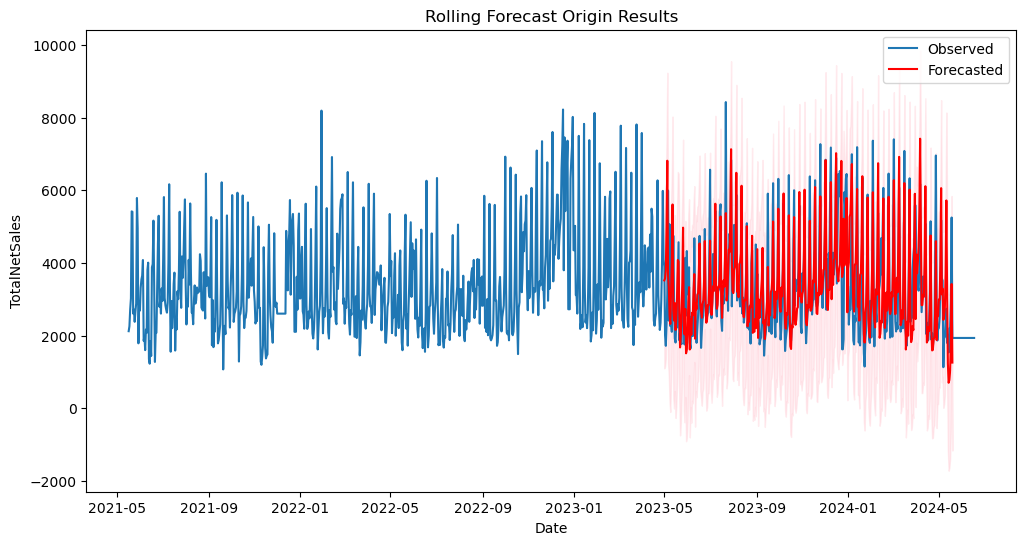

In [23]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Parsing dates in .*")
warnings.filterwarnings('ignore', category=FutureWarning, message=".*fillna.*")
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning, message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.")
warnings.filterwarnings('ignore', category=UserWarning, message="This pattern has match groups")

# Load and prepare data
data = pd.read_csv('Test_Combined_Sales_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)  # Ensure correct date format
data.drop_duplicates(subset='Date', inplace=True)  # Remove duplicate dates
data.set_index('Date', inplace=True)
data = data.asfreq('D').ffill()  # Forward fill to ensure continuity

# Fill missing values for exogenous variables if necessary
data['feelslike'].ffill(inplace=True)
data['Is_Holiday'].ffill(inplace=True)

# Add Pre-Christmas feature
data['year'] = data.index.year
data['pre_christmas'] = 0
for year in data['year'].unique():
    pre_christmas_start = pd.to_datetime(f'{year}-12-11')
    pre_christmas_end = pd.to_datetime(f'{year}-12-24')
    data.loc[(data.index >= pre_christmas_start) & (data.index <= pre_christmas_end), 'pre_christmas'] = 1

# Define exogenous variables including the pre-Christmas feature
exog_vars = ['feelslike', 'Is_Holiday', 'pre_christmas']

# Standardize exogenous variables
scaler = StandardScaler()
data[exog_vars] = scaler.fit_transform(data[exog_vars])

# Function for rolling forecast origin
def rolling_forecast_origin(data, exog_vars, start, end, step):
    history = data.loc[:start]
    predictions = []
    actuals = []
    
    for t in pd.date_range(start, end, freq=f'{step}D'):
        try:
            model = SARIMAX(history['TotalNetSales'], order=(3,1,0), seasonal_order=(1,0,1,7),
                            exog=history[exog_vars], enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            forecast = model_fit.forecast(steps=step, exog=data.loc[t:t+pd.Timedelta(days=step-1), exog_vars])
            predictions.extend(forecast)
            actuals.extend(data.loc[t:t+pd.Timedelta(days=step-1), 'TotalNetSales'])
            history = pd.concat([history, data.loc[t:t+pd.Timedelta(days=step-1)]])
        except np.linalg.LinAlgError as e:
            print(f"LinAlgError encountered at {t}: {e}")
            continue
        except ValueError as e:
            print(f"ValueError encountered at {t}: {e}")
            continue
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    # Calculate MAPE
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    # Calculate SMAPE
    smape = np.mean(2.0 * np.abs(np.array(actuals) - np.array(predictions)) / (np.abs(np.array(actuals)) + np.abs(np.array(predictions)))) * 100
    
    print(f'Test MSE: {mse}')
    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')
    print(f'Test R^2: {r2}')
    print(f'Test MAPE: {mape:.2f}%')
    print(f'Test SMAPE: {smape:.2f}%')
    
    return predictions, actuals

# Define start and end points for the rolling forecast
start = pd.to_datetime('2023-05-01')  # Ensure this date exists in your data
end = pd.to_datetime('2024-05-19')    # Ensure this date exists in your data
step = 7  # Forecast one week at a time

# Run the rolling forecast origin
predictions, actuals = rolling_forecast_origin(data, exog_vars, start, end, step)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalNetSales'], label='Observed')
plt.plot(pd.date_range(start=start, periods=len(predictions), freq='D'), predictions, label='Forecasted', color='red')
plt.fill_between(pd.date_range(start=start, periods=len(predictions), freq='D'), 
                 np.array(predictions) - 1.96*np.std(predictions), 
                 np.array(predictions) + 1.96*np.std(predictions), color='pink', alpha=0.3)
plt.title('Rolling Forecast Origin Results')
plt.xlabel('Date')
plt.ylabel('TotalNetSales')
plt.legend()
plt.show()
